# Test for loading VCF files

To test out ga4gh information, make sure to also run:

```bash
python -m pip install ga4gh.vrs[extras] seqrepo
```

Also you have to load the reference genome into the seqrepo repository first:

```bash
seqrepo --root-directory data load -i references -n NCBI reference/2011C-3609.fasta
```

Additional modules.

```bash
python -m pip instal biopython scipy bitvector
```

## find core

In [40]:
from Bio import SeqIO
from Bio import Align

def find_core(files: List[str]):
    contigs = {}
    alignments = {}
    for file in files:
        for record in SeqIO.parse(file, 'fasta'):
            if record.id not in contigs:
                contigs[record.id] = []
            record.seq = record.seq.upper()
            contigs[record.id].append(record)
    
    for k in contigs.keys():
        alignments[k] = Align.MultipleSeqAlignment(contigs[k])
        print(alignments[k])
        
    return alignments
        
fa_dir = 'data/snps-aligned'
files = [os.path.join(fa_dir, f) for f in os.listdir(fa_dir)]
files = [f for f in files if f.endswith('.fa')]

alignments = find_core(files)

Alignment with 9 rows and 1052450 columns
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCCTGAAATCTTTA...--- JASV01000007.1
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...--- JASV01000007.1
TACCGGTTTTCCTGTGCCGTCTTTCAGTACACCTGAAATCTTTA...--- JASV01000007.1
TACCGGTTTTCCTGTGCCGTCTTTCAGTACACCTGAAATCTTTA...--- JASV01000007.1
NNNNNNNNNNNNNNNNNNGTCTTTCAGTACACCTGAAATCTTTA...--- JASV01000007.1
NACCGGTTTTCCTGTGCCGTCTTTCAGTACACCTGAAATCTTTA...--- JASV01000007.1
TACCGGTTTTCCTGTGCCGTCTTTCAGTACACCTGAAATCTTTA...--- JASV01000007.1
NNNNNNNNNNNNNNNNNNGTCTTTCAGTACACCTGAAATCTTTA...--- JASV01000007.1
NNNNNNNNNNNNNNNNNNGTCTTTCAGTACACCTGAAATCTTTA...--- JASV01000007.1
Alignment with 9 rows and 521264 columns
--------------------------------------------...NNN JASV01000001.1
--------------------------------------------...--- JASV01000001.1
--------------------------------------------...NNN JASV01000001.1
--------------------------------------------...NNN JASV01000001.1
--------------------------------------------...NNN JASV0100

In [41]:
alignments['JASV01000002.1'].substitutions

Array([[6.3310e+03, 0.0000e+00, 0.0000e+00, 7.5150e+02, 4.0000e+00],
       [0.0000e+00, 1.0419e+04, 0.0000e+00, 1.0715e+03, 0.0000e+00],
       [0.0000e+00, 0.0000e+00, 7.6500e+03, 9.3350e+02, 0.0000e+00],
       [7.5150e+02, 1.0715e+03, 9.3350e+02, 2.8330e+03, 7.0300e+02],
       [4.0000e+00, 0.0000e+00, 0.0000e+00, 7.0300e+02, 8.3500e+03]],
         alphabet='ACGNT')

In [84]:
from BitVector import BitVector

def generate_mask(alignments):
    masks = {}
    
    for name in alignments:
        align = alignments[name]
        mask_length = align.get_alignment_length()
        mask = BitVector(size=mask_length)
        mask.reset(1)

        for record in align:
            for idx, char in enumerate(record.seq):
                if char == 'N' or char == '-':
                    mask[idx] = 0
                    
        masks[name] = mask
        
    return masks
                    
masks = generate_mask(alignments)
masks['JASV01000002.1']

In [85]:
print(masks['JASV01000002.1'])

0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

## pyvcf

In [1]:
# Code from https://gist.github.com/dceoy/99d976a2c01e7f0ba1c813778f9db744
from typing import List
import vcf
import pandas as pd
import re
import os

def read_vcf(file: str) -> pd.DataFrame:
    reader = vcf.Reader(open(file, 'r'))
    df = pd.DataFrame([vars(r) for r in reader])
    out = df.merge(pd.DataFrame(df.INFO.tolist()),
                   left_index=True, right_index=True)
    out = out[['CHROM', 'POS', 'REF', 'ALT', 'DP', 'QUAL', 'RO', 'AO', 'INFO']]
    out['TYPE'] = out['INFO'].map(lambda x: x['TYPE'][0])
    out = out.drop('INFO', axis='columns')
    out['ALT'] = out['ALT'].map(lambda x: x[0])
    out['AO'] = out['AO'].map(lambda x: x[0])
    cols = out.columns.tolist()
    out['FILE'] = os.path.basename(file)
    out = out.reindex(columns=['FILE'] + cols)
    return out

def read_vcfs(files: List[str]) -> pd.DataFrame:
    frames = [read_vcf(f) for f in files]
    return pd.concat(frames)

In [2]:
directory = 'data/snps-vcf'
files = [os.path.join(directory, f) for f in os.listdir('data/snps-vcf')]
files = [f for f in files if f.endswith('.vcf')]

df = read_vcfs(files)
df = df[df['TYPE'] == 'snp']
df

,FILE,CHROM,POS,REF,ALT,DP,QUAL,RO,AO,TYPE
0,2014C-3857.filt.vcf,JASV01000001.1,16854,T,C,38,1175.580,0,38,snp
2,2014C-3857.filt.vcf,JASV01000001.1,16897,G,C,25,735.848,0,25,snp
6,2014C-3857.filt.vcf,JASV01000001.1,17360,T,A,19,429.886,0,19,snp
7,2014C-3857.filt.vcf,JASV01000001.1,17468,T,C,56,1823.480,0,56,snp
10,2014C-3857.filt.vcf,JASV01000001.1,50643,A,C,28,860.187,0,28,snp
...,...,...,...,...,...,...,...,...,...,...
125,2014C-3600.filt.vcf,JASV01000007.1,767386,A,G,87,2684.540,0,87,snp
126,2014C-3600.filt.vcf,JASV01000007.1,890046,T,C,96,3115.580,0,96,snp
127,2014C-3600.filt.vcf,JASV01000007.1,958303,T,G,93,3115.200,0,93,snp
128,2014C-3600.filt.vcf,JASV01000007.1,963356,A,G,23,692.768,0,23,snp


## Naming variants

In [3]:
dfn = df.copy()
#dfn['VARIANT'] = df.apply(lambda r: f'{r.CHROM}:{r.POS}:{r.POS + len(r.ALT)}:{r.ALT}', axis=1)
dfn['VARIANT'] = df.apply(lambda r: f'{r.CHROM}:{r.REF}:{r.POS}:{r.ALT}', axis=1)
dfn

,FILE,CHROM,POS,REF,ALT,DP,QUAL,RO,AO,TYPE,VARIANT
0,2014C-3857.filt.vcf,JASV01000001.1,16854,T,C,38,1175.580,0,38,snp,JASV01000001.1:T:16854:C
2,2014C-3857.filt.vcf,JASV01000001.1,16897,G,C,25,735.848,0,25,snp,JASV01000001.1:G:16897:C
6,2014C-3857.filt.vcf,JASV01000001.1,17360,T,A,19,429.886,0,19,snp,JASV01000001.1:T:17360:A
7,2014C-3857.filt.vcf,JASV01000001.1,17468,T,C,56,1823.480,0,56,snp,JASV01000001.1:T:17468:C
10,2014C-3857.filt.vcf,JASV01000001.1,50643,A,C,28,860.187,0,28,snp,JASV01000001.1:A:50643:C
...,...,...,...,...,...,...,...,...,...,...,...
125,2014C-3600.filt.vcf,JASV01000007.1,767386,A,G,87,2684.540,0,87,snp,JASV01000007.1:A:767386:G
126,2014C-3600.filt.vcf,JASV01000007.1,890046,T,C,96,3115.580,0,96,snp,JASV01000007.1:T:890046:C
127,2014C-3600.filt.vcf,JASV01000007.1,958303,T,G,93,3115.200,0,93,snp,JASV01000007.1:T:958303:G
128,2014C-3600.filt.vcf,JASV01000007.1,963356,A,G,23,692.768,0,23,snp,JASV01000007.1:A:963356:G


In [4]:
dfv = dfn.groupby('VARIANT').agg({'FILE': lambda x: set(x), 'CHROM': 'first',
                                  'POS': 'first', 'REF': 'first', 'ALT': 'first'})
dfv['COUNT'] = dfv['FILE'].map(lambda x: len(x))
dfv

,FILE,CHROM,POS,REF,ALT,COUNT
VARIANT,,,,,,
JASV01000001.1:A:100054:G,"{2014C-3655.filt.vcf, 2014C-3907.filt.vcf, 201...",JASV01000001.1,100054,A,G,4
JASV01000001.1:A:110713:C,"{2014C-3655.filt.vcf, 2014C-3907.filt.vcf, 201...",JASV01000001.1,110713,A,C,4
JASV01000001.1:A:17085:G,"{2014C-3656.filt.vcf, 2014C-3598.filt.vcf, 201...",JASV01000001.1,17085,A,G,5
JASV01000001.1:A:180279:G,"{2014C-3656.filt.vcf, 2014C-3857.filt.vcf, 201...",JASV01000001.1,180279,A,G,9
JASV01000001.1:A:245696:G,{2014C-3857.filt.vcf},JASV01000001.1,245696,A,G,1
...,...,...,...,...,...,...
JASV01000007.1:T:728676:A,{2014C-3850.filt.vcf},JASV01000007.1,728676,T,A,1
JASV01000007.1:T:750118:C,{2014C-3840.filt.vcf},JASV01000007.1,750118,T,C,1
JASV01000007.1:T:890046:C,"{2014C-3656.filt.vcf, 2014C-3857.filt.vcf, 201...",JASV01000007.1,890046,T,C,9


In [5]:
dfc1 = dfv[dfv['CHROM'] == 'JASV01000001.1'].sort_values(by='POS')
dfc1.head(3)

,FILE,CHROM,POS,REF,ALT,COUNT
VARIANT,,,,,,
JASV01000001.1:T:16854:C,"{2014C-3656.filt.vcf, 2014C-3857.filt.vcf, 201...",JASV01000001.1,16854,T,C,9
JASV01000001.1:G:16897:C,"{2014C-3656.filt.vcf, 2014C-3857.filt.vcf, 201...",JASV01000001.1,16897,G,C,9
JASV01000001.1:A:17085:G,"{2014C-3656.filt.vcf, 2014C-3598.filt.vcf, 201...",JASV01000001.1,17085,A,G,5


<AxesSubplot:ylabel='Frequency'>

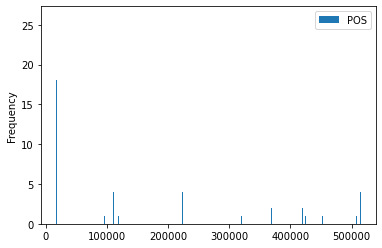

In [6]:
import matplotlib

dfc1.plot(kind='hist', y='POS', weights=dfc1['COUNT'], bins=1000)

<AxesSubplot:xlabel='POS'>

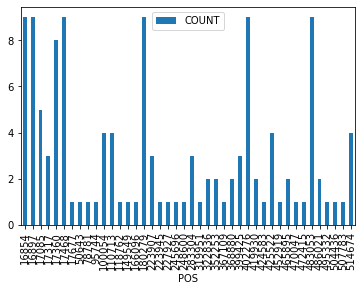

In [80]:
dfc1.plot(kind='bar', x='POS', y='COUNT')

## Naming variants with ga4gh API

In [3]:
from biocommons.seqrepo import SeqRepo
import ga4gh.vrs.dataproxy as dataproxy

sr = SeqRepo("data/references")
dp = dataproxy.SeqRepoDataProxy(sr)
dp

In [7]:
sr.translate_identifier('JASV01000001.1')

['MD5:0e80efeb2f25ebd46745f2b819fb6980',
 'NCBI:JASV01000001.1',
 'refseq:JASV01000001.1',
 'SEGUID:DJRZITn7OCNqqFqW22j9EZeMOKs',
 'SHA1:0c94592139fb38236aa85a96db68fd11978c38ab',
 'VMC:GS_vG4MeGaVc32nhjmPtFzbpTsbPs1uZjVU',
 'sha512t24u:vG4MeGaVc32nhjmPtFzbpTsbPs1uZjVU',
 'ga4gh:SQ.vG4MeGaVc32nhjmPtFzbpTsbPs1uZjVU']

In [29]:
from ga4gh.vrs.extras.translator import Translator

tlr = Translator(data_proxy=dp,
                 translate_sequence_identifiers=True,
                 normalize=True,
                 identify=True)

#tlr.translate_from("refseq:JASV01000001.1:10:11:A", fmt='spdi')
#tlr.translate_from('refseq:JASV01000001.1 : 100 G > C')

In [30]:
#df.apply(lambda r: tlr.translate_from(f'{r.CHROM}:{r.POS}:{r.POS + 1}:{r.ALT}'), axis=1)

# Directly using pandas

In [76]:
def read_vcfs_pandas(files: List[str]) -> pd.DataFrame:
    frames = [read_vcf_pandas(f) for f in files]
    return pd.concat(frames)

def read_vcf_pandas(file: str) -> pd.DataFrame:
    return pd.read_csv(file, sep='\t', header=32)

df = read_vcf_pandas('data/snps-vcf/2014C-3598.filt.vcf')
df

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,2014C-3598
0,JASV01000001.1,16677,.,A,AC,372.853,.,AB=0;AO=15;DP=16;QA=461;QR=0;RO=0;TYPE=ins,GT:DP:RO:QR:AO:QA:GL,"1/1:16:0:0:15:461:-41.4117,-4.51545,0"
1,JASV01000001.1,16854,.,T,C,712.836,.,AB=0;AO=24;DP=24;QA=830;QR=0;RO=0;TYPE=snp,GT:DP:RO:QR:AO:QA:GL,"1/1:24:0:0:24:830:-75.0095,-7.22472,0"
2,JASV01000001.1,16871,.,CA,C,473.949,.,AB=0;AO=18;DP=21;QA=555;QR=0;RO=0;TYPE=del,GT:DP:RO:QR:AO:QA:GL,"1/1:21:0:0:18:555:-50.0082,-5.41854,0"
3,JASV01000001.1,16897,.,G,C,560.494,.,AB=0;AO=20;DP=20;QA=687;QR=0;RO=0;TYPE=snp,GT:DP:RO:QR:AO:QA:GL,"1/1:20:0:0:20:687:-62.1438,-6.0206,0"
4,JASV01000001.1,17085,.,A,G,581.626,.,AB=0;AO=21;DP=21;QA=732;QR=0;RO=0;TYPE=snp,GT:DP:RO:QR:AO:QA:GL,"1/1:21:0:0:21:732:-66.191,-6.32163,0"
...,...,...,...,...,...,...,...,...,...,...
114,JASV01000007.1,728264,.,A,G,1704.980,.,AB=0;AO=51;DP=52;QA=1934;QR=13;RO=1;TYPE=snp,GT:DP:RO:QR:AO:QA:GL,"1/1:52:1:13:51:1934:-173.006,-14.3536,0"
115,JASV01000007.1,767386,.,A,G,943.829,.,AB=0;AO=31;DP=31;QA=1087;QR=0;RO=0;TYPE=snp,GT:DP:RO:QR:AO:QA:GL,"1/1:31:0:0:31:1087:-98.1184,-9.33193,0"
116,JASV01000007.1,890046,.,T,C,1427.930,.,AB=0;AO=46;DP=46;QA=1622;QR=0;RO=0;TYPE=snp,GT:DP:RO:QR:AO:QA:GL,"1/1:46:0:0:46:1622:-146.239,-13.8474,0"
117,JASV01000007.1,958303,.,T,G,1130.970,.,AB=0;AO=35;DP=35;QA=1298;QR=0;RO=0;TYPE=snp,GT:DP:RO:QR:AO:QA:GL,"1/1:35:0:0:35:1298:-117.103,-10.5361,0"
